### CNN on CIFAR 10 DATASET:

1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use Dense Layers (also called fully connected layers), or DropOut.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
10. You cannot have more than 1 Million parameters in total
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

In [0]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.chdir('/content/gdrive/My Drive')

In [0]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 10
l = 6
num_filter = 35
compression = 1
dropout_rate = 0.2

In [4]:
import tensorflow as tf
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

170500096/170498071 [==============================] - 6s 0us/step


### About the dataset:

* Download the data from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
* The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research.
* The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes.
* The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. 

* There are 6,000 images of each class.
* Let's look at a few images in the dataset.

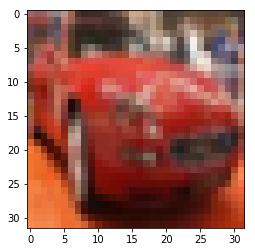

In [4]:
plt.imshow(X_train[5])

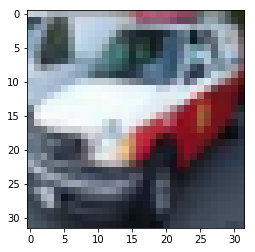

In [5]:
plt.imshow(X_train[60])

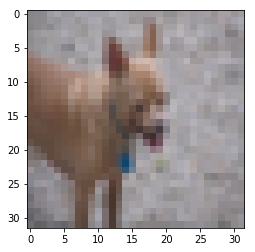

In [6]:
plt.imshow(X_train[260])

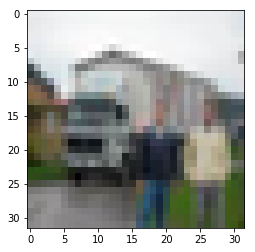

In [7]:
plt.imshow(X_train[16])

In [0]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    #output layer - FCN
    conv_layer = layers.Conv2D(10, (1,1), use_bias=False ,padding='same')(AvgPooling)
    last = layers.GlobalMaxPooling2D()(conv_layer)
    output = layers.Activation('softmax')(last)
    return output

In [10]:

dropout_rate = 0.2

input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 35)   945         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 35)   140         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 35)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
#checkpoint your model after every epoch
#and retrain the model from that checkpoint so that there won't be a need of 
#training the model from first if you lost at any epoch while training. 
#You can directly load that model and Train from that epoch.
import os
from keras.callbacks import ModelCheckpoint
import datetime

save_dir = os.getcwd()
file_name = str(datetime.datetime.now()).split(' ')[0] + '_{epoch:02d}.hdf5'
filepath = os.path.join(save_dir, file_name)



checkpoints = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,
                                save_best_only=False, save_weights_only=False,
                                mode='auto', period=1)

Using TensorFlow backend.


In [0]:
# create data generator
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )
datagen.fit(X_train)
# prepare iterator
it_train = datagen.flow(X_train, y_train, batch_size=batch_size)
steps = int(X_train.shape[0] / batch_size)

In [0]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [15]:
###############Fit Model #############################
history = model.fit_generator(
it_train, steps_per_epoch=steps,
epochs = 100,
validation_data=(X_test, y_test),
callbacks = [checkpoints],
shuffle= True)

Epoch 1/100
389/390 [============================>.] - ETA: 0s - loss: 1.5346 - acc: 0.4364
Epoch 00001: saving model to /content/gdrive/My Drive/2019-09-26_01.hdf5
390/390 [==============================] - 191s 489ms/step - loss: 1.5336 - acc: 0.4367 - val_loss: 1.7033 - val_acc: 0.4601
Epoch 2/100
389/390 [============================>.] - ETA: 0s - loss: 1.1160 - acc: 0.6014
Epoch 00002: saving model to /content/gdrive/My Drive/2019-09-26_02.hdf5
390/390 [==============================] - 167s 427ms/step - loss: 1.1154 - acc: 0.6016 - val_loss: 2.0776 - val_acc: 0.4789
Epoch 3/100
389/390 [============================>.] - ETA: 0s - loss: 0.9490 - acc: 0.6609
Epoch 00003: saving model to /content/gdrive/My Drive/2019-09-26_03.hdf5
390/390 [==============================] - 167s 428ms/step - loss: 0.9486 - acc: 0.6611 - val_loss: 2.8773 - val_acc: 0.4386
Epoch 4/100
389/390 [============================>.] - ETA: 0s - loss: 0.8375 - acc: 0.7033
Epoch 00004: saving model to /content/

In [16]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 10s 1ms/sample - loss: 0.3422 - acc: 0.9051
Test loss: 0.3422499177105725
Test accuracy: 0.9051


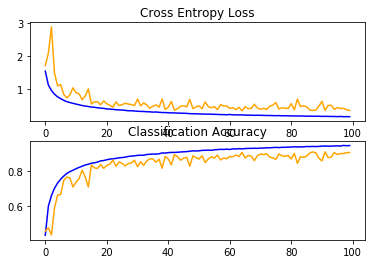

In [17]:
%matplotlib inline 
import matplotlib.pyplot as plt

plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')

# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['acc'], color='blue', label='train')
plt.plot(history.history['val_acc'], color='orange', label='test')
filename = 'cnn_cifar10'
plt.savefig(filename + '_plot.png')
plt.show()
plt.close()

### Summary:
* We found that the accuracy of the DenseNet model was low,so in order to improve the performance we performed data augmentation on the existing baseline DenseNet model.
* Also Changed the number of filters and compression value which seemed to work well.

* So from the accuracy and cross entropy loss  values,it is evident that the model's performance has significantly improved when data augmentation was used along with the existing baseline model.
* We got a test accuracy value to be more than 0.9051 at the end of 100 epochs.